# Performing a Multivariate Regression

The regression analysis we have applied in the other notebooks treats each dependent variable independently, with a different model for each. However, such an approach does not preserve the covariance/correlations between these dependent variables, therefore we should use multivariate regression to predict all three response variables simultaneously. To undertake this analysis, we will use the "Extra Trees Regressor" from the scikit-learn library but we could also use other regressors such as:

 1. Ordinary Least Squares Linear regressor
 2. Partial Least Squares (PLS) regressor
 3. Elastic Net regressor
 4. Kernel Ridge regressor
 5. k-Nearest Neighbours regressor
 6. Extra Trees regressor




# 1. Imports

In [1]:
import os

import joblib
import matplotlib.cm
import matplotlib.colors as mcolors
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import numpy
import pandas
import rsgislib.imageutils
import rsgislib.regression
import rsgislib.regression.regresssklearn
import rsgislib.tools.plotting
import rsgislib.tools.mapping
import rsgislib.tools.utils
import scipy.stats
import sklearn.model_selection
from sklearn.ensemble import ExtraTreesRegressor

/home/pete/.conda/envs/osgeo-env-v9/lib/python3.10/site-packages/rsgislib/tools/mapping.py:11: UserWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas will still use PyGEOS by default for now. To force to use and test Shapely 2.0, you have to set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In a future release, GeoPandas will switch to using Shapely by default. If you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas


In [2]:
%matplotlib inline

# 2. Read the input plot data 

In [3]:
# Open the CSV file as a Pandas data frame - the df variable.
df = pandas.read_csv("../data/lidar/Forest_Plot_Metrics_LassoLars_Sel.csv", index_col=0)

# Get a list of the columns within the df dataframe
cols = list(df.columns)

# Get the indepedent predictor column names
ind_vars = cols[6:]

# Get the dependent response column names
dep_vars = cols[3:6]

# 3. Create output directory

In [4]:
out_dir = "et_multivar_reg_outputs"
if not os.path.exists(out_dir):
    os.mkdir(out_dir)

# 4. Performing a grid-search for optimal hyper-parameters

Before we can perform the regression analysis, we must tune our models to ensure that we are using the optimal hyper-parameters. The optimal hyper-parameters are specific to each algorithm and will vary depending on the training data.

A grid-search is one popular method of identifying the optimal hyper-parameters. In an exhaustive grid search, a matrix of all possible parameter combinations is generated (e.g. using latin hypercube sampling). Each parameter combination is then tested and accuracy metrics are computed (using cross-validation) to determine how well the model was able to fit the training data. We can identify the best hyper-parameters by finding the parameter combinations that have produced the highest accuracy scores (or lowest errors).

A grid search can take a long time (e.g., several hours) when we want to test all possible hyper-parameter combinations on a large training dataset (e.g., > 100,000 samples). To speed up the process, we can randomly sample the parameter grid rather than test all possible parameter combinations. This approach is less accurate than performing an exhaustive search.

To find the optimal parameters the following steps needs to be undertaken, example given using the ExtraTreesRegressor algorithm. 

## 4.1 Read the field plot data in using Pandas as we’ve done in the other scripts

*Already done*

## 4.2 Split out the dependent and predictor variables from the dataframe



In [5]:
# Get the predictor variables and dependent variables
# from the dataframe as numpy arrays
x = df[ind_vars].values
y = df[dep_vars].values

## 4.3 Get the ExtraTreesRegressor object and parameters to be searched.
 
The function call creates the grid of parameters to be searched, the ExtraTreesRegressor class instance and returns a Boolean as to whether the input data should be scaled or not.

In [6]:
# Get the Extra Trees Regressor Object and Grid Search Parameters
(
    regrs_obj,
    regrs_params,
    scale_data,
) = rsgislib.regression.regresssklearn.get_et_obj_params(len(ind_vars))

## 4.4 Rescale the data if needed. 

In this case, we are using the scikit-learn StandardScaler (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) which standardizes features by removing the mean and scaling to unit variance. (*Note, for Extra Trees scaling is not needed*). 

In [7]:
if scale_data:
    from sklearn.preprocessing import StandardScaler

    data_scaler = StandardScaler()
    data_scaler.fit(x)
else:
    data_scaler = None


## 4.5 Get a subset of the data

Parameter optimisation is computationally expensive so we cannot use the full datasets.


In [8]:
# Randomly sample the input data to create training and testing (20% sample) datasets
# so we have an independent dataset to test the quality of the relationship
x_train, x_test, y_train, y_test = sklearn.model_selection.train_test_split(
    x, y, test_size=0.2, random_state=0
)

# Split the training data to have a subset for optimising the parameters.
# Using a subset significantly speeds up this analysis.
x_data, x_opt_data, y_data, y_opt_data = sklearn.model_selection.train_test_split(
    x_train, y_train, test_size=0.3, random_state=0
)

## 4.6 Create a hyperparameter search object (GridSearchCV or RandomizedSearchCV)

In [9]:
# Create the search (Grid Search or Random Search) object
skl_srch_obj = rsgislib.regression.regresssklearn.create_search_obj(
    regrs_obj, regrs_params, n_runs=5, n_cv=2, n_cores=2
)

## 4.7 Perform the parameter search and save those ‘best’ parameters for future use.

*Note. this can take quite a long time to run!*

If this does take a long time to run, you can skip running the this box as the required file, outputted from the function below, has been provided.

In [10]:
%%script false --no-raise-error
# If you want to run this cell comment out line above.

# Perform the parameter search
opt_params_file = os.path.join(out_dir, "regrs_opt_params_et.json")
skl_regrs_opt_obj = rsgislib.regression.regresssklearn.perform_search_param_opt(
    opt_params_file,
    x_opt_data,
    y_opt_data,
    skl_srch_obj=skl_srch_obj,
    data_scaler=data_scaler,
)

# 5. Regression analysis with k-fold cross-validation

Having found the optimal hyper-parameters for each machine learning algorithm, we can proceed with the regression analysis. Since we lack independent test data to evaluate each regression model, **resampling methods** must be employed to evaluate the **accuracy** and **precision** of each model:

![Regression Fitting Methods](figures/regression_fitting_methods.png)

In this tutorial, we will use the train-test split method, with 80% of the forest inventory plots used for training and 20% for validation. Here is a summary of the procedure:

 * randomly shuffle the data to remove any ordering,
 * split the data into training and test partitions (80% training, 20% test),
 * fit the regressor on the training sample and then generate predictions for the test sample,
 * calculate accuracy statistics to measure the prediction error on the test sample.

This description illustrates just one iteration of the train-test split. However, if we want to evaluate the **precision** (i.e., stability) of the regression model, we must perform **several replicates** of the train-test split. By performing several iterations/replicates, **we can evaluate how robust the regression model is to sampling variations**.

Note. By performing several iterations/replicates of the cross-validation procedure, we are **attempting to mimic the variability that would exist if several independent forest inventories were collected in our study region** (i.e. we would expect the training data to differ between separate forest inventories due to sampling variations).

A model that is overfitted to the training data will have a high bias, whereas a model that is underfitted will have high variance. The optimal model will generate unbiased predictions whilst also being robust to variations in the training data (bias-variance tradeoff).


## 5.1 Read the Optimised Parameters from file
These are the parameters which can be created in the previous step.

In [11]:
# Read in the optimised parameters for the Extra Trees Model
opt_params_file = "../data/lidar/regrs_opt_params_et.json"
skregrs_params = rsgislib.tools.utils.read_json_to_dict(opt_params_file)
skregrs_params

{'max_depth': 5,
 'max_features': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

## 5.2 Create the Instanace with the parameters for the Regressor

In [12]:
skregrs_obj = ExtraTreesRegressor(**skregrs_params)

## 5.3 Perform a kfold Model Fit

In [13]:
metrics, residuals = rsgislib.regression.regresssklearn.perform_kfold_fit(
    skregrs_obj, x, y, n_splits=5, repeats=20, shuffle=False, data_scaler=data_scaler
)

0it [00:00, ?it/s]Future exception was never retrieved
future: <Future finished exception=BrokenPipeError(32, 'Broken pipe')>
Traceback (most recent call last):
  File "/home/pete/.conda/envs/osgeo-env-v9/lib/python3.10/asyncio/unix_events.py", line 676, in write
    n = os.write(self._fileno, data)
BrokenPipeError: [Errno 32] Broken pipe
100it [00:07, 12.73it/s]


## 5.4 Export Metrics and Residuals

In [14]:
for i, dep_var in enumerate(dep_vars):
    # Remove spaces (replaced with underscores) and any puntuation from
    # the variable name so it can be used within as part of the output
    # file name
    dep_var_chk = rsgislib.tools.utils.check_str(
        dep_var, rm_non_ascii=True, rm_dashs=True, rm_spaces=True, rm_punc=True
    ).lower()

    df_metrics = pandas.DataFrame(data=metrics[i])
    # Save the dataframe to a CSV file.
    out_csv_file = os.path.join(
        out_dir, "Forest_Plot_Regres_Metrics_ET_{}.csv".format(dep_var_chk)
    )
    df_metrics.to_csv(out_csv_file)

    df_residuals = pandas.DataFrame(data=residuals[i])
    # Save the dataframe to a CSV file.
    out_csv_file = os.path.join(
        out_dir, "Forest_Plot_Regres_Residuals_ET_{}.csv".format(dep_var_chk)
    )
    df_residuals.to_csv(out_csv_file)

## 5.5 Summarise Metrics

The next step is to summarise metrics we have just outputted from the previous code so we can try and understand the quality of the results and if we had run multiple regression algorithms then which had provided the best results. 

For this analysis we want to summarise each individual set of outputs for each of the dependent variable. The metrics we will focus on are:

 1. The coefficient of determination (r2),
 2. Root Mean Square Error (RMSE),
 3. Bias.

**Note**. *When comparing quoted values to your results or running multiple times, you likely find that your values are slightly different and this is because the plot data is randomly shuffled during the kfold and your shuffles will be different to mine and each time you run the analysis and therefore the results will be slightly different.*


As the name implies, the RMSE is the square root of the mean squared errors between our predicted and observed response variables:

$
\text{RMSE} = \sqrt{\sum_{i=0}^{n}{\frac{(\hat{y}_{i} - y_{i})^{2}}{n}}}
$

RMSE quantifies the quadratic mean error of our regression model in the same units of measurement as our original data. For example, for the Extra Trees regressor, the RMSE for mean DBH was 3.3 cm, whilst the RMSE for basal area was 7.7 m2 ha-1.


To compare RMSE values across variables with different measurement units, we can normalise the RMSE into a percentage error by dividing the RMSE by the mean of the response variable and then multiplying by 100:

$
n\text{RMSE} (\%) = 100 \times \frac{\text{RMSE}}{\bar{y}} 
$

We can now easily compare the RMSE values across all of our response variables, for example for ET:
 * nRMSE of mean DBH = 19.7%
 * nRMSE of basal area per hectare = 20.8%
 * nRMSE of stem volume per hectare = 22.1%.

The bias of an estimator is another important accuracy measure. It is simply the mean difference between our predicted and observed response variables:

$
\text{Bias} = \sum_{i=1}^{n}\frac{\hat{y}_{i} - y_{i}}{n}
$

Like RMSE, bias is quantified in the same measurement units as our original data. However, bias can be positive or negative. Negative bias indicates that our model is, on average, underestimating the true values in our response variables. Conversely, positive bias indicates that our model is overestimating the true/observed values in our response variables.

An unbiased estimator (bias = zero) is preferable to a biased model (bias not zero), however biased estimators are frequently used when:
 1. an unbiased estimator is not available, or
 2. a biased estimator gives significantly lower RMSE or higher r2 values.

To allow bias values to be compared across variables with different measurement units, we can normalise the absolute bias into a percentage by dividing the bias by the mean of the response variable and then multiplying by 100:

$
n\text{Bias} (\%) = 100 \times \frac{Bias}{\bar{y}} 
$


In [15]:
for i, dep_var in enumerate(dep_vars):
    print(dep_var)
    metric_cols = list(metrics[i])
    for metric in metric_cols:
        print(
            "\t{}: Min: {}, Mean: {}, Median: {}, Max:{}, Std Dev: {}".format(
                metric,
                numpy.min(metrics[i][metric]),
                numpy.mean(metrics[i][metric]),
                numpy.median(metrics[i][metric]),
                numpy.max(metrics[i][metric]),
                numpy.std(metrics[i][metric]),
            )
        )

Mean DBH
	r2: Min: 0.41158803103284125, Mean: 0.7119053870908943, Median: 0.7185941303390277, Max:0.8652490148508959, Std Dev: 0.07645287673340669
	explained_variance_score: Min: 0.48192710519131277, Mean: 0.7263119283043903, Median: 0.7303836133940355, Max:0.8696963969446012, Std Dev: 0.07353875859147506
	median_absolute_error: Min: 1.0042178807188709, Mean: 1.620408906497742, Median: 1.5923551231700417, Max:2.598031250612131, Std Dev: 0.34826268403429356
	mean_absolute_error: Min: 1.6461016308362064, Mean: 2.332749362386197, Median: 2.262694395906464, Max:3.7235193381890124, Std Dev: 0.40581544363842975
	mean_squared_error: Min: 4.657252259416865, Mean: 11.920672969481595, Median: 10.311107515444085, Max:30.38408988604382, Std Dev: 5.390169069204076
	root_mean_squared_error: Min: 2.158066787524627, Mean: 3.3727719734927577, Median: 3.2110865308280916, Max:5.512176510784449, Std Dev: 0.738296813147234
	norm_root_mean_squared_error: Min: 12.564634687300929, Mean: 19.63382863166523, Med

## 5.6. Plot Residuals

A residual plot is a useful method of visually investigating the distribution of errors in our regression model. We can use the residual plot to investigate both the normality and homoscedasticity of the model errors.


In [16]:
# Get residuals as dataframes for each dependent variable
for i, dep_var in enumerate(dep_vars):
    if dep_var == "BA / ha":
        df_ba_res = pandas.DataFrame(data=residuals[i])
    elif dep_var == "Vol / ha":
        df_vol_res = pandas.DataFrame(data=residuals[i])
    elif dep_var == "Mean DBH":
        df_dbh_res = pandas.DataFrame(data=residuals[i])

In [17]:
ba_y_true = df_ba_res["y_true"].values
ba_residuals = df_ba_res["y_pred"].values - ba_y_true

ba_resid_plt_file = os.path.join(out_dir, "et_residuals_plot_ba.png")
rsgislib.tools.plotting.residual_plot(
    ba_y_true,
    ba_residuals,
    ba_resid_plt_file,
    title="Residuals for Basal Area ET Regression",
)

In [18]:
dbh_y_true = df_dbh_res["y_true"].values
dbh_residuals = df_dbh_res["y_pred"].values - dbh_y_true

dbh_resid_plt_file = os.path.join(out_dir, "et_residuals_plot_dbh.png")
rsgislib.tools.plotting.residual_plot(
    dbh_y_true,
    dbh_residuals,
    dbh_resid_plt_file,
    title="Residuals for DBH ET Regression",
)

In [19]:
vol_y_true = df_vol_res["y_true"].values
vol_residuals = df_vol_res["y_pred"].values - vol_y_true

vol_resid_plt_file = os.path.join(out_dir, "et_residuals_plot_vol.png")
rsgislib.tools.plotting.residual_plot(
    vol_y_true,
    vol_residuals,
    vol_resid_plt_file,
    title="Residuals for Stem Volume ET Regression",
)

![BA Residuals](figures/et_residuals_plot_ba.png)
![DbH Residuals](figures/et_residuals_plot_dbh.png)
![Volume Residuals](figures/et_residuals_plot_vol.png)

From these plots we can see that there is a clear trend in our residuals which indicates that our ET model is underestimating plots with larger values. For example, for plots with a stem volume > 600 m2 ha-1 there is a clear underestimation. If we were to investigate this further, it is likely that we would find that there are a small number of plots with high stem volume and therefore the training data has not well sampled these plots so the model is not well fitted to these plots. If it would possible, we could look to increase the number of these plot without are training dataset.

## 5.7 Investigating the normality of residuals

A quantile-quantile plot is a useful method of visually investigating whether the errors/residuals from our model follow a normal (Gaussian) distribution.

In python, a Q-Q plot can be produced using the scipy.stats.probplot() function. The code has been prepared for you to generate a Q-Q plot showing the normality of residuals for basal area, mean DBH and stem volume per hectare for the linear model:


In [20]:
ba_resid_qq_plt_file = os.path.join(out_dir, "et_residuals_qq_plot_ba.png")
rsgislib.tools.plotting.quantile_plot(
    ba_residuals,
    "Basal Area error (m$^2$ ha$^{-1}$)",
    ba_resid_qq_plt_file,
    title="Residuals for Basal Area OSL Regression",
)

dbh_resid_qq_plt_file = os.path.join(out_dir, "et_residuals_qq_plot_dbh.png")
rsgislib.tools.plotting.quantile_plot(
    dbh_residuals,
    "DBH error (cm)",
    dbh_resid_qq_plt_file,
    title="Residuals for DBH OSL Regression",
)

vol_resid_qq_plt_file = os.path.join(out_dir, "et_residuals_qq_plot_vol.png")
rsgislib.tools.plotting.quantile_plot(
    vol_residuals,
    "Volume error (m$^3$ ha$^{-1}$)",
    vol_resid_qq_plt_file,
    title="Residuals for Stem Volume OSL Regression",
)

![BA QQ Residuals](figures/et_residuals_qq_plot_ba.png)
![DbH QQ Residuals](figures/et_residuals_qq_plot_dbh.png)
![Volume QQ Residuals](figures/et_residuals_qq_plot_vol.png)

The Q-Q plots demonstrates that our residuals deviate from a normal distribution (represented by the red line). This is especially noticeable for plots with low stem volumes and low DBH values.

To test the significance of these deviations from normality, we can use several functions available in SciPy:
 * Shapiro-Wilk Test - scipy.stats.shapiro()
 * Kolmogorov-Smirnov Test - scipy.stats.kstest()
 * Anderson-Darling Test - scipy.stats.anderson()

We will use the Shapiro-Wilk Test, where the null hypothesis for this test is that the sample is normally distributed. 


In [21]:
pval, w = scipy.stats.shapiro(ba_residuals)
print("ba: p = {}".format(round(pval, 4)))
if pval > 0.05:
    print(
        "Accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval (BA)"
    )
else:
    print(
        "Reject the null hypothesis that the residuals are Gaussian at the 95% confidence interval (BA)"
    )

ba: p = 0.9688
Accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval (BA)


In [22]:
pval, w = scipy.stats.shapiro(dbh_residuals)
print("dbh: p = {}".format(round(pval, 4)))
if pval > 0.05:
    print(
        "Accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval (dbh)"
    )
else:
    print(
        "Reject the null hypothesis that the residuals are Gaussian at the 95% confidence interval (dbh)"
    )

dbh: p = 0.8766
Accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval (dbh)


In [23]:
pval, w = scipy.stats.shapiro(vol_residuals)
print("vol: p = {}".format(round(pval, 4)))
if pval > 0.05:
    print(
        "Accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval (vol)"
    )
else:
    print(
        "Reject the null hypothesis that the residuals are Gaussian at the 95% confidence interval (vol)"
    )

vol: p = 0.9055
Accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval (vol)


Our p-value is greater than 0.05, therefore we must accept the null hypothesis that the residuals are Gaussian at the 95% confidence interval. If the p-value was < 0.05, we would accept the alternative hypothesis that the residuals are non-Gaussian at the 95% confidence interval.

# 6. Creating the Final Model

We are now ready to apply our model to the image data, the first step is to build the final model and save it for future analysis. To save a scikit-learn model we commonly use the joblib module as recommended by the scikit-learn documentation: https://scikit-learn.org/stable/modules/model_persistence.html. It should be noted that when you’ve saved a model with the joblib module, that model might not be able to be loaded with other versions of scikit-learn depending on what changes occur within the scikit-learn library. You also need to be using the same version of Python, for example if you save the model with Python 3.7 and then try and open it with 3.8 or 3.9 it most likely will not work!


## 6.1 Read the Optimised Parameters File

In [24]:
# Read in the optimised parameters for the Extra Trees Model
opt_params_file = "../data/lidar/regrs_opt_params_et.json"
skregrs_params = rsgislib.tools.utils.read_json_to_dict(opt_params_file)
skregrs_params

{'max_depth': 5,
 'max_features': 9,
 'min_samples_leaf': 1,
 'min_samples_split': 4,
 'n_estimators': 100}

## 6.2 Create the Instanace with the parameters for the Regressor

In [25]:
skregrs_obj = ExtraTreesRegressor(**skregrs_params)

## 6.3 Fit the Model

In [26]:
# Note x and y were defined in section 4.2 :)

skregrs_obj.fit(x, y)

ExtraTreesRegressor(max_depth=5, max_features=9, min_samples_split=4)

## 6.3 Save Model to File

In [27]:
# Output model file
output_mdl_file = os.path.join(out_dir, "Forest_Reg_ET_Model.joblib")

# Save regression model to disk:
print("Saving regression model...")
joblib.dump(skregrs_obj, output_mdl_file, ("gzip", 1))
print("Saved regression model.")

Saving regression model...
Saved regression model.


## 6.4 Check that the Saved Model loads...

You probably don't need this step but it can be useful to double check if it is a file you intend to reuse and come back to. 

In [28]:
# Verify that the model can be read from disk:
print("Attempting to read regression model from disk...")
regrs_test_mdl = joblib.load(output_mdl_file)
regrs_test_mdl.predict(x)
print("Read model and used it predict successfully.")

Attempting to read regression model from disk...
Read model and used it predict successfully.


# 7. Apply Model to Image Data

To apply the model, we cannot use band maths as we did previously as the model is providing multiple output (i.e., 3). Therefore, we need to use the scikit-learn model directly. To do this we will use the apply_regress_sklearn_mdl function which is within RSGISLib.

To ensure we are only applying the regression model to valid regions (i.e., pixel which are forest!) we provide a valid data mask (Forest_ALS_Valid.kea) alongside the LiDAR metrics image (Forest_ALS_Metrics.kea). We need to provide a list of image band numbers to the apply_regress_sklearn_mdl function as we are just using the 12 metrics identified using the LassoLars feature selection method - **Note, these need to be the same and in the same order as used to train the regressor**. The image band numbering starts at 1. 


In [29]:
# Define Input Images
input_img = "../data/lidar/Forest_ALS_Metrics.kea"
vld_msk_img = "../data/lidar/Forest_ALS_Valid.kea"

In [30]:
# Image bands in the metrics image used by the model.
metrics_band_idxs = [24, 27, 41, 42, 43, 46, 47, 48, 49, 51, 52, 61]

In [31]:
# Define the output options for GTIFF.
rsgislib.imageutils.set_env_vars_lzw_gtiff_outs()

In [32]:
# Output Image
output_img = os.path.join(out_dir, "ALS_Forest_Estimates.tif")
out_band_names = ["Basal Area", "Mean DBH", "Stem Volume"]

# Apply the model to the image data
rsgislib.regression.regresssklearn.apply_regress_sklearn_mdl(
    skregrs_obj,
    3,
    input_img,
    metrics_band_idxs,
    vld_msk_img,
    1,
    output_img,
    gdalformat="GTIFF",
    out_band_names=out_band_names,
    calc_stats=True,
    out_no_date_val=0.0,
)

Applying the Regression model


  0%|          | 0/100 [00:00<?, ?it/s]

Completed


Calculating Image Pyramids.





# 8. Visualise Results

You should now have the image ALS_Forest_Estimates.tif created and you can open it in TuiView or QGIS. However, we can also makes some plots using Python.


Image Data Size: 501 x 538
Image Data Size: 501 x 538
Image Data Size: 501 x 538


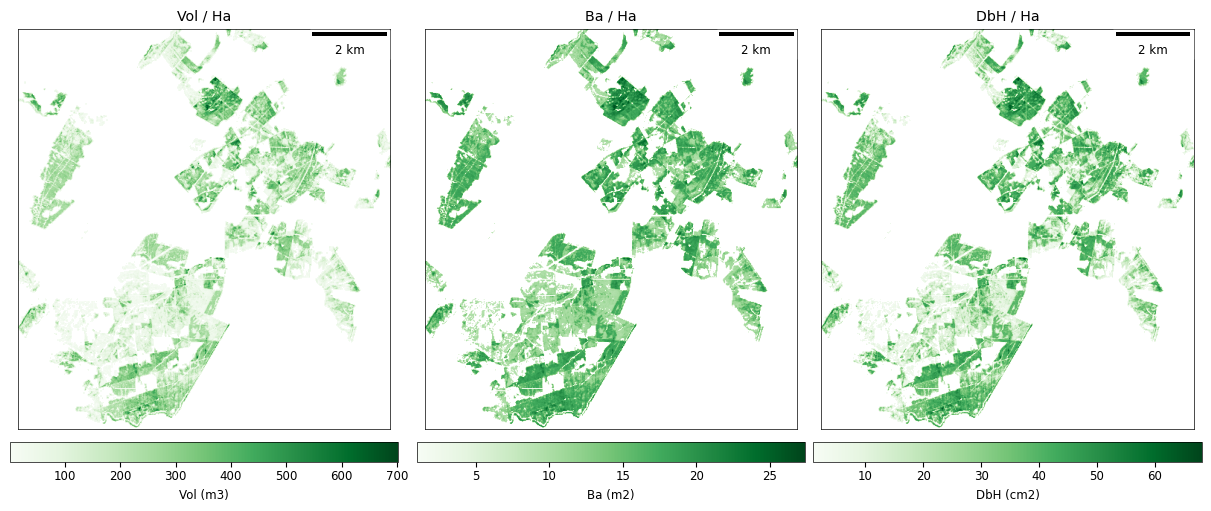

In [33]:
sub_bbox = [291171, 301190, 246680, 257452]

fig = plt.figure(figsize=(12, 5), constrained_layout=True)  #
gspec = gridspec.GridSpec(
    ncols=3,
    nrows=2,
    height_ratios=[1, 0.05],
    width_ratios=[1, 1, 1],
    figure=fig,
)

ax_00 = fig.add_subplot(gspec[0, 0])
vol_cmap, vol_norm = rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax=ax_00,
    input_img=output_img,
    img_band=3,
    bbox=sub_bbox,
    title_str="Vol / Ha",
    show_scale_bar=True,
    use_grid=False,
    show_map_axis=True,
    cmap_name="Greens",
    norm_img_vals=True,
    use_log_norm=False,
    norm_vmin=1,
    norm_vmax=None,
    vals_under_white=True,
)
ax_00.set_xticks([])
ax_00.set_yticks([])

ax_10 = fig.add_subplot(gspec[1, 0])
cbar = fig.colorbar(
    mappable=matplotlib.cm.ScalarMappable(norm=vol_norm, cmap=vol_cmap),
    cax=ax_10,
    orientation="horizontal",
    ticklocation="bottom",
    label="Vol (m3)",
)

ax_01 = fig.add_subplot(gspec[0, 1])
ba_cmap, ba_norm = rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax=ax_01,
    input_img=output_img,
    img_band=1,
    bbox=sub_bbox,
    title_str="Ba / Ha",
    show_scale_bar=True,
    use_grid=False,
    show_map_axis=True,
    cmap_name="Greens",
    norm_img_vals=True,
    use_log_norm=False,
    norm_vmin=1,
    norm_vmax=None,
    vals_under_white=True,
)
ax_01.set_xticks([])
ax_01.set_yticks([])

ax_11 = fig.add_subplot(gspec[1, 1])
cbar = fig.colorbar(
    mappable=matplotlib.cm.ScalarMappable(norm=ba_norm, cmap=ba_cmap),
    cax=ax_11,
    orientation="horizontal",
    ticklocation="bottom",
    label="Ba (m2)",
)


ax_02 = fig.add_subplot(gspec[0, 2])
dbh_cmap, dbh_norm = rsgislib.tools.mapping.create_raster_cmap_img_map(
    ax=ax_02,
    input_img=output_img,
    img_band=2,
    bbox=sub_bbox,
    title_str="DbH / Ha",
    show_scale_bar=True,
    use_grid=False,
    show_map_axis=True,
    cmap_name="Greens",
    norm_img_vals=True,
    use_log_norm=False,
    norm_vmin=1,
    norm_vmax=None,
    vals_under_white=True,
)
ax_02.set_xticks([])
ax_02.set_yticks([])

ax_12 = fig.add_subplot(gspec[1, 2])
cbar = fig.colorbar(
    mappable=matplotlib.cm.ScalarMappable(norm=dbh_norm, cmap=dbh_cmap),
    cax=ax_12,
    orientation="horizontal",
    ticklocation="bottom",
    label="DbH (cm2)",
)